The aim of this project is to predict crime locations using latitutde and longitude coordinates given features extracted from Toronto Police MCI reports

In [6]:
import pandas as pd
import numpy as np

In [12]:
data = pd.read_csv('Major_Crime_Indicators.csv') 
data.head()

C:\Users\Moham\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


X             Y  Index_ event_unique_id Division  \
0 -8.859749e+06  5.423033e+06   10182  GO-20142103239      D23   
1 -8.861050e+06  5.426864e+06   10298  GO-20142111528      D23   
2 -8.861412e+06  5.422084e+06   10300  GO-20142111859      D23   
3 -8.859955e+06  5.424372e+06   10345  GO-20142116041      D23   
4 -8.859955e+06  5.424372e+06   10346  GO-20142116041      D23   

           occurrencedate            reporteddate premises_type  ucr_code  \
0  2014/05/18 04:00:00+00  2014/05/18 04:00:00+00         House      1430   
1  2014/05/19 04:00:00+00  2014/05/19 04:00:00+00       Outside      1430   
2  2014/05/19 04:00:00+00  2014/05/19 04:00:00+00     Apartment      2120   
3  2014/05/20 04:00:00+00  2014/05/20 04:00:00+00       Outside      1420   
4  2014/05/20 04:00:00+00  2014/05/20 04:00:00+00       Outside      1420   

   ucr_ext  ... occurrenceday  occurrencedayofyear occurrencedayofweek  \
0      100  ...          18.0                138.0              Sunday   
1      100  ...          19.0                139.0              Monday   
2      200  ...          19.0                139.0              Monday   
3      100  ...          20.0                140.0             Tuesday   
4      110  ...          20.0                140.0             Tuesday   

   occurrencehour              MCI Hood_ID               Neighbourhood  \
0              12          Assault       1  West Humber-Clairville (1)   
1              20          Assault       1  West Humber-Clairville (1)   
2              22  Break and Enter       1  West Humber-Clairville (1)   
3              14          Assault       1  West Humber-Clairville (1)   
4              14          Assault       1  West Humber-Clairville (1)   

        Long        Lat  ObjectId  
0 -79.588477  43.725321         1  
1 -79.600166  43.750187         2  
2 -79.603420  43.719158         3  
3 -79.590332  43.734013         4  
4 -79.590332  43.734013         5  

[5 rows x 29 columns]

### Section 1: Exploratory analysis and data preprocessing

#### Identify relevant categorical and numerical feature columns

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242879 entries, 0 to 242878
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    242879 non-null  float64
 1   Y                    242879 non-null  float64
 2   Index_               242879 non-null  int64  
 3   event_unique_id      242879 non-null  object 
 4   Division             242879 non-null  object 
 5   occurrencedate       242879 non-null  object 
 6   reporteddate         242879 non-null  object 
 7   premises_type        242879 non-null  object 
 8   ucr_code             242879 non-null  int64  
 9   ucr_ext              242879 non-null  int64  
 10  offence              242879 non-null  object 
 11  reportedyear         242879 non-null  int64  
 12  reportedmonth        242879 non-null  object 
 13  reportedday          242879 non-null  int64  
 14  reporteddayofyear    242879 non-null  int64  
 15  reporteddayofweek

In [14]:
int64_cols = [col for col in data.columns if data[col].dtype == 'int64']
int64_cols, len(int64_cols)

(['Index_',
  'ucr_code',
  'ucr_ext',
  'reportedyear',
  'reportedday',
  'reporteddayofyear',
  'reportedhour',
  'occurrencehour',
  'ObjectId'],
 9)

In [15]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars, len(cat_vars)

(['event_unique_id',
  'Division',
  'occurrencedate',
  'reporteddate',
  'premises_type',
  'offence',
  'reportedmonth',
  'reporteddayofweek',
  'occurrencemonth',
  'occurrencedayofweek',
  'MCI',
  'Hood_ID',
  'Neighbourhood'],
 13)

In [16]:
# Hood_ID and Neighbourhood seem to overlap and may give rise to colinearity, so we'll drop one of them
len(data['Hood_ID'].unique()), len(data['Neighbourhood'].unique())

(142, 141)

Given hood ids are sometimes reported as strings and sometimes as integers, we'll use the Neighbourhood awhich doesn't contain overlapping neighbourhood names, as opposed to Hood_ID which contains overlapping neighbourhood id 136:

In [17]:
list(set(data["Hood_ID"]))[130:]

[131, 132, 133, 134, 135, 136, 'NSA', '137', '138', '140', '136', '139']

In [18]:
# float columns
float_cols = [var for var in data.columns if data[var].dtype == 'float64']
float_cols, len(float_cols)

(['X',
  'Y',
  'occurrenceyear',
  'occurrenceday',
  'occurrencedayofyear',
  'Long',
  'Lat'],
 7)

In [19]:
# we'll only require the 'ucr code' and 'occurence hour' from the int64 columns
INT_COLS = ['occurrencehour']

# from the categorial columns, we'll drop columns with 'reported', the 'division', 'hood_id', 'offence' (substituting
# 'MCI' instead) to reduce cardinality; we'll also remove the 'occurence date' since we won't be doing 
# a time series analysis

CAT_COLS = ['event_unique_id',
          'premises_type',
          'occurrencemonth',
          'occurrencedayofweek',
          'MCI',
          'Neighbourhood']

# we'll use 'Long' and 'Lat' from the float64 columns instead of X, Y and drop the latter, we'll also keep 
# the occurence variables for feature engineering

FLOAT_COLS = [
  'occurrenceday',
  'occurrencedayofyear',
  'Long',
  'Lat']

features = INT_COLS + CAT_COLS + FLOAT_COLS[:-2]
targets =  FLOAT_COLS[-2:]

#### Check duplicate records numbers...

In [20]:
np.unique(data["event_unique_id"])

array(['GO-20141035797', 'GO-20141056448', 'GO-20141086943', ...,
       'GO-2020999554', 'GO-2020999573', 'GO-2020999999'], dtype=object)

...where a crime incident report features more than one crime:

In [21]:
data["event_unique_id"].value_counts().head()

GO-20151785704    24
GO-2015840772     16
GO-2019817050     12
GO-20152031940    12
GO-20201445580    11
Name: event_unique_id, dtype: int64

In [22]:
data[data['event_unique_id'] == "GO-20151785704"].head()

X             Y  Index_ event_unique_id Division  \
168764 -8.838352e+06  5.415131e+06   51965  GO-20151785704      D53   
168766 -8.838352e+06  5.415131e+06   51966  GO-20151785704      D53   
168768 -8.838352e+06  5.415131e+06   51967  GO-20151785704      D53   
168770 -8.838352e+06  5.415131e+06   51968  GO-20151785704      D53   
168772 -8.838352e+06  5.415131e+06   51969  GO-20151785704      D53   

                occurrencedate            reporteddate premises_type  \
168764  2015/10/16 04:00:00+00  2015/10/16 04:00:00+00    Commercial   
168766  2015/10/16 04:00:00+00  2015/10/16 04:00:00+00    Commercial   
168768  2015/10/16 04:00:00+00  2015/10/16 04:00:00+00    Commercial   
168770  2015/10/16 04:00:00+00  2015/10/16 04:00:00+00    Commercial   
168772  2015/10/16 04:00:00+00  2015/10/16 04:00:00+00    Commercial   

        ucr_code  ucr_ext  ... occurrenceday  occurrencedayofyear  \
168764      1480      110  ...          16.0                289.0   
168766      1480      110  ...          16.0                289.0   
168768      1480      110  ...          16.0                289.0   
168770      1480      110  ...          16.0                289.0   
168772      1480      110  ...          16.0                289.0   

       occurrencedayofweek  occurrencehour      MCI Hood_ID  Neighbourhood  \
168764              Friday              20  Assault      95     Annex (95)   
168766              Friday              20  Assault      95     Annex (95)   
168768              Friday              20  Assault      95     Annex (95)   
168770              Friday              20  Assault      95     Annex (95)   
168772              Friday              20  Assault      95     Annex (95)   

             Long        Lat  ObjectId  
168764 -79.396265  43.674004    168765  
168766 -79.396265  43.674004    168767  
168768 -79.396265  43.674004    168769  
168770 -79.396265  43.674004    168771  
168772 -79.396265  43.674004    168773  

[5 rows x 29 columns]

In [23]:
data = data.drop_duplicates(subset=['event_unique_id']).reset_index()

#### Dealing with NaNs

In [24]:
print(features+targets)
[(col, sum(data[col].isna())) for col in features+targets]

['occurrencehour', 'event_unique_id', 'premises_type', 'occurrencemonth', 'occurrencedayofweek', 'MCI', 'Neighbourhood', 'occurrenceday', 'occurrencedayofyear', 'Long', 'Lat']


[('occurrencehour', 0),
 ('event_unique_id', 0),
 ('premises_type', 0),
 ('occurrencemonth', 60),
 ('occurrencedayofweek', 60),
 ('MCI', 0),
 ('Neighbourhood', 0),
 ('occurrenceday', 60),
 ('occurrencedayofyear', 60),
 ('Long', 0),
 ('Lat', 0)]

The null values appear to coincide in terms of value counts, let's check if they actually coincide in terms of record number

In [25]:
features_with_na = ["occurrencemonth", "occurrencedayofweek", "occurrenceday", "occurrencedayofyear"]
na_set = set()
for col in features_with_na:
    [na_set.add(i) for i in data[data[col].isna()].index]
len(na_set)

60

In [26]:
data[data.index.isin(na_set)][["occurrencedate", "reporteddate"]].head(10)

occurrencedate            reporteddate
2133   1995/01/01 05:00:00+00  2018/08/25 04:00:00+00
12284  1999/01/01 05:00:00+00  2019/03/13 04:00:00+00
13868  1996/01/01 05:00:00+00  2015/10/20 04:00:00+00
14835  1980/01/01 05:00:00+00  2020/10/02 04:00:00+00
17312  1966/06/09 04:00:00+00  2015/04/17 04:00:00+00
28367  1998/01/01 05:00:00+00  2015/06/23 04:00:00+00
30536  1995/01/01 05:00:00+00  2014/10/15 04:00:00+00
32215  1989/01/01 05:00:00+00  2018/10/24 04:00:00+00
35242  1978/04/10 04:00:00+00  2014/04/24 04:00:00+00
47627  1976/07/01 04:00:00+00  2018/01/05 05:00:00+00

One observation is that such records are crimes that had occurred in the 60s-90s but were only reported recently, in the past 8 years. One way to deal with them is to extract date time features as demonstrated below, but looking through the extracted values, they appear **arbitrarily** recorded since they mostly fall on the first month of the year, on the first day of the month. This may be due to those reporting older crimes having faint memories of when they happened. In that case, **it is better to drop the null records** considering they comprise only 60 records.

In [27]:
data_ = data[features+["occurrencedate"]].copy().astype('O')
for i in range(len(data_[data_.index.isin(na_set)])):
    date = pd.Timestamp(data_[data_.index.isin(na_set)].iloc[i, :].occurrencedate)
    print(
          "dayofyear : ", date.dayofyear,
          "dayofmonth : ", date.day,
          "month : ", date.month, 
          "dayofweek : ", date.dayofweek)

dayofyear :  1 dayofmonth :  1 month :  1 dayofweek :  6
dayofyear :  1 dayofmonth :  1 month :  1 dayofweek :  4
dayofyear :  1 dayofmonth :  1 month :  1 dayofweek :  0
dayofyear :  1 dayofmonth :  1 month :  1 dayofweek :  1
dayofyear :  160 dayofmonth :  9 month :  6 dayofweek :  3
dayofyear :  1 dayofmonth :  1 month :  1 dayofweek :  3
dayofyear :  1 dayofmonth :  1 month :  1 dayofweek :  6
dayofyear :  1 dayofmonth :  1 month :  1 dayofweek :  6
dayofyear :  100 dayofmonth :  10 month :  4 dayofweek :  0
dayofyear :  183 dayofmonth :  1 month :  7 dayofweek :  3
dayofyear :  305 dayofmonth :  1 month :  11 dayofweek :  2
dayofyear :  1 dayofmonth :  1 month :  1 dayofweek :  1
dayofyear :  83 dayofmonth :  24 month :  3 dayofweek :  2
dayofyear :  152 dayofmonth :  1 month :  6 dayofweek :  0
dayofyear :  1 dayofmonth :  1 month :  1 dayofweek :  4
dayofyear :  31 dayofmonth :  31 month :  1 dayofweek :  2
dayofyear :  353 dayofmonth :  19 month :  12 dayofweek :  4
dayofyear :

In [28]:
data.dropna(axis=0, inplace=True)
len(data[data.index.isin(na_set)])

0

Seeing as how there are no other **NaNs** in the dataset, the Toronto Police did record an **NSA** - not specified area - for certain columns. These comprise roughly 1100 datapoints that should be dealt with either by dropping the rows or imputing reasonable values.

In [29]:
# this function iterates through columns and rows to identify our targetted missing value and which columns contain it
def find_nsa(missing_indicator: str, data: pd.DataFrame):
    assert isinstance(data, pd.DataFrame)
    cols_with_missing_values = list()
    for col in list(data[features].columns):
        unqiue_elements = np.unique(data[col].astype("str"))
        if missing_indicator in unqiue_elements:
            cols_with_missing_values.append(col)
    return cols_with_missing_values

find_nsa(missing_indicator="NSA", data=data)

['Neighbourhood']

Luckily, only the Neighbourhood column contains records with NSA

*One way to deal with this* is to map the neighbourhoods of such records to match neighbourhoods of other records with the closest long/lat coordinates. This will require 1000 x 242879 or ~ 242 million total caclulations to minimze the distance.

In [30]:
len(data[data['Neighbourhood'] == 'NSA']), len(data)

(1000, 211306)

*An alternative approach* would be to get an average coordiante location for a neighboughood but averaging out coordinate locations for all records for that neighbourhood (to arrive at a single Long/Lat coordiante - call it a cluster centre). then our NSA records could be assigned a neighbourhood based on the Long/Lat of the NSA record and the closest neighbourhood cluster centre. This would result 1000 x 141 or ~ 141 000 total calculations to minimize the distance. This 'informal clustering approach' seems like a more pragmatic but arguably less accurate approach.

In [31]:
len(data[data['Neighbourhood'] == 'NSA']), len(np.unique(data['Neighbourhood']))

(1000, 141)

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class ReplaceNSA(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nsa_column = "Neighbourhood"
        self.targets = ["Long", "Lat"]
        self.distance = 1000

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        self.XY = pd.concat((X, y), axis=1)
        self.cluster_centres = pd.concat(
            (
                self.XY.groupby(self.nsa_column)[y.columns[0]].mean(),
                self.XY.groupby(self.nsa_column)[y.columns[1]].mean(),
            ),
            axis=1,
        )

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        self.nsa_records = self.XY[self.XY[self.nsa_column] == "NSA"][self.targets]

        for row, index in zip(self.nsa_records.values, self.nsa_records.index):
            for i, cc in enumerate(self.cluster_centres.values):
                new_distance = (row[0] - cc[0]) ** 2 + (row[1] - cc[1]) ** 2
                if new_distance < self.distance:
                    self.distance = new_distance
                    shortest_idx = i
            X[self.nsa_column][index] = self.cluster_centres.index[shortest_idx]
            self.distance = 1000
        return X
        

In [33]:
replacer = ReplaceNSA()

In [35]:
# although our transformer returns the tranformed X to facilitate integration into
# a scikit-learn pipeline, it can be used on the entire data
data = fitted_replacer.transform(data)
data[data.index.isin(fitted_replacer.nsa_records.index)]["Neighbourhood"]

C:\Users\Moham\AppData\Local\Temp/ipykernel_7848/1945173213.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.nsa_column][index] = self.cluster_centres.index[shortest_idx]


209683               West Humber-Clairville (1)
209684                            Steeles (116)
209685                Kensington-Chinatown (78)
210367                           Moss Park (73)
210368                         Black Creek (24)
                          ...                  
211361                            Steeles (116)
211362             Centennial Scarborough (133)
211363               West Humber-Clairville (1)
211364                    Newtonbrook East (50)
211365    Mount Olive-Silverstone-Jamestown (2)
Name: Neighbourhood, Length: 1000, dtype: object

In [34]:
fitted_replacer = replacer.fit(X=data[data.columns[:-3]], y=data[data.columns[-3:-1]])

The records above show that most of the neighbourhoods assigned belong to outlying neighbourhoods of Toronto including Etobicoke, Scarborough, etc. This can be confirmed by plotting previous NSA records on a map.

- Plotting the NSA records locations (indicated by the smaller blue dots) that have been assigned to the closest neighbourhood clusters indicated by the larger red dots.

- The map should concern us since most of the GTA lies outside the jurisdiction of the Toronto Police meaning neighbourhoods in GTA districts like Etbicoke, Mississauga and North York form the outter bounds of the TPD's jurisdiction and concern. 

In [36]:
import folium
map1 = folium.Map(prefer_canvas=True)

def plotDot(cell, lat: str = "Lat", long: str="Long", cc: bool = False, colour: str = "blue", map=map1):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    if not cc:
        folium.CircleMarker(location=[cell[lat], cell[long]],
                       radius=1,
                       weight=2,
                        color = colour).add_to(map)
    else:
        folium.CircleMarker(location=[cell[lat], cell[long]],
                       radius=3,
                       weight=3,
                       color = "red").add_to(map)  
    

# use df.apply(,axis=1) to "iterate" through every row in your dataframe
fitted_replacer.nsa_records[["Lat", "Long"]].apply(plotDot, axis = 1, cc=False, map=map1)
fitted_replacer.cluster_centres[["Lat", "Long"]].apply(plotDot, axis = 1, cc=True, map=map1)

# Set the zoom to the maximum possible
map1.fit_bounds(map1.get_bounds())
map1

Visualize geospatial distribution of crime type according to MCI (crime type)

In [190]:
# we'll "label encode" MCI crime types
mapper = {j: i for i, j in enumerate(np.unique(data_["MCI"]))}
data["MCI_label"] = data["MCI"]
data["MCI_label"].replace(mapper, inplace = True)                                  

map2 = folium.Map(prefer_canvas=True)

colours = ["green", "blue", "orange", "black", "red"]
def plotDot_(point, lat: str = "Lat", long: str="Long", label: str="", map_name: object= map1):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point[lat], point[long]],
                   radius=1,
                   weight=2,
                   color = colours[int(point[label])]
                   ).add_to(map_name)

data[["Lat", "Long", "MCI_label"]].sample(2000).apply(plotDot_, label = "MCI_label", map_name = map2, axis = 1)

# Set the zoom to the maximum possible
map2.fit_bounds(map2.get_bounds())
map2

In [191]:
mapper = {j: i for i, j in enumerate(np.unique(data_["occurrencedayofweek"].astype(str)))}
data["occurrencedayofweek_label"] = data["occurrencedayofweek"]
data["occurrencedayofweek_label"].replace(mapper, inplace = True)

map3 = folium.Map(prefer_canvas=True)

colours = ["green", "blue", "orange", "black", "red", "purple", "yellow"]

data[["Lat", "Long", "occurrencedayofweek_label"]].sample(2000).apply(plotDot_, 
                                                                      label = "occurrencedayofweek_label",
                                                                      map_name=map3,
                                                                      axis = 1)

map3.fit_bounds(map3.get_bounds())
map3

##### A useful visualization is premises type

We can confirm that transit-based crimes (indicated by yellow in the map below) do indeed fall on major roads, intersections and subway lines

In [192]:
mapper = {j: i for i, j in enumerate(np.unique(data_["premises_type"].astype(str)))}
colours = ["green", "blue", "orange", "black", "red", "purple", "yellow"]
mapper

{'Apartment': 0,
 'Commercial': 1,
 'Educational': 2,
 'House': 3,
 'Other': 4,
 'Outside': 5,
 'Transit': 6}

In [193]:
data["premises_type_label"] = data["premises_type"]
data["premises_type_label"].replace(mapper, inplace = True)

map4 = folium.Map(prefer_canvas=True)


data[["Lat", "Long", "premises_type_label"]].sample(2000).apply(plotDot_, 
                                                                      label = "premises_type_label",
                                                                      map_name=map4,
                                                                      axis = 1)

map4.fit_bounds(map4.get_bounds())
map4

We can also visual the balance of values for different features (the equivalent for testing a normal or a skewed distribution in the vase of continuous values).

Some important observations on the charts below  are: some neighbourhoods feature a lot more crimes, but that may be due to size or resident density; crimes occurences are highest at noon and midnight, this could be due to a deafault time of day being assigned to records where the exact time of crime occurrence is not known; there is a large an imbalance in terms of the premises and crime types in our dataset.

In short, it is hard to make any sort of causal by only eye-balling the distributions.

In [194]:
import matplotlib.pyplot as plt

In [195]:
features = data[features]
features.drop("event_unique_id", axis=1, inplace=True)
targets = data[targets]

C:\Users\Moham\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [196]:
features.columns, targets.columns

(Index(['occurrencehour', 'premises_type', 'occurrencemonth',
        'occurrencedayofweek', 'MCI', 'Neighbourhood', 'occurrenceday',
        'occurrencedayofyear'],
       dtype='object'),
 Index(['Long', 'Lat'], dtype='object'))

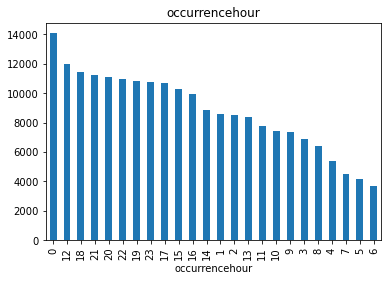

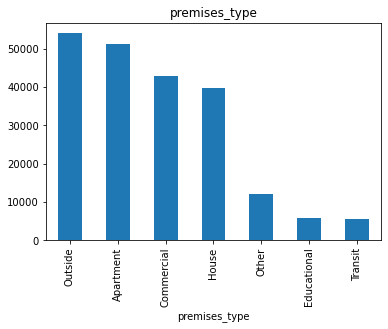

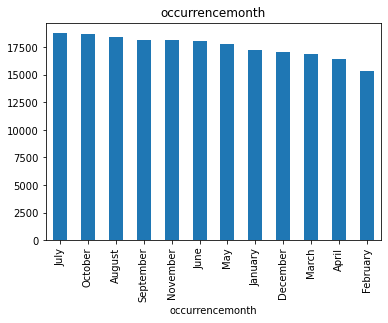

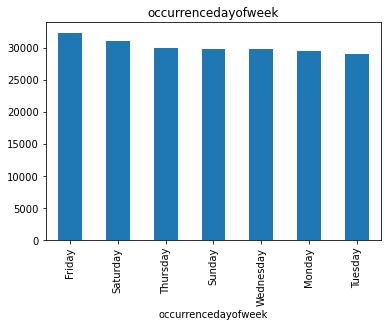

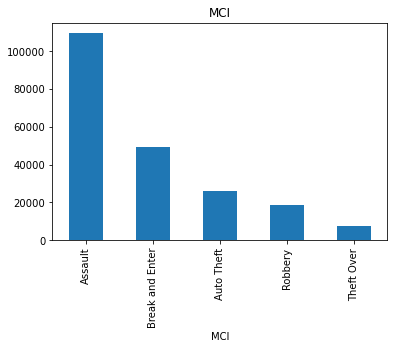

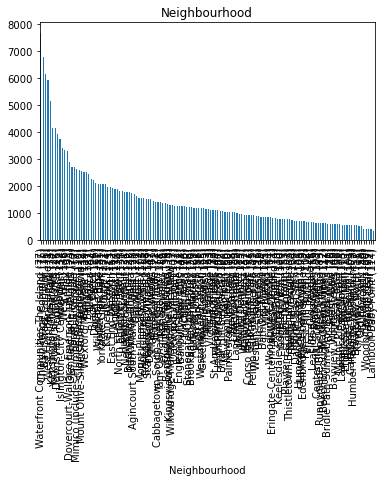

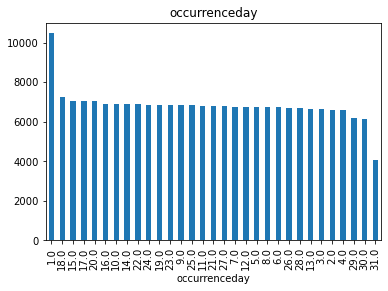

In [197]:
def plot(col: str, data: pd.DataFrame):
    # the count feature can be any feature    
    features.groupby(col).count()["occurrencedayofyear"].sort_values(ascending= False).plot.bar(title=col) 
    plt.show()

for i, col in enumerate(features.columns[:-1]):
    plot(col, features)


Before wrapping up data exporation and preprocessing, it's relevant to checkout which of our features have rare categories. We notice below that of the rare categories are neighbourhoods that represent 1 or 0.5 of 1% of all crime incidents. The rarity of these labels are justified since we will be using neighbourhood to home in on the crime location when making predictions.

In [198]:
def get_rare_cat(data, feature, tol):
    temp = data.copy()
    temp = temp.groupby(feature)["occurrencedayofyear"].count() / len(data) # any aggregating feature works for counting
    return temp[temp < tol]

for col in features.columns:
    if col != "occurrencedayofyear":  
        rare_cats = get_rare_cat(features, col, 0.01)
        if len(rare_cats) > 0: 
            print(rare_cats)
            print()

Neighbourhood
Agincourt North (129)                 0.005646
Agincourt South-Malvern West (128)    0.008036
Alderwood (20)                        0.002839
Banbury-Don Mills (42)                0.005882
Bathurst Manor (34)                   0.004051
                                        ...   
Woodbine-Lumsden (60)                 0.001879
Wychwood (94)                         0.003999
Yonge-Eglinton (100)                  0.003724
Yonge-St.Clair (97)                   0.001860
Yorkdale-Glen Park (31)               0.009815
Name: occurrencedayofyear, Length: 117, dtype: float64



### Section 2: Feature engineering, training and testing using existing features

Here we attempt to crate bins out of granular categorical features after having removed duplicates or NSA records. 

In [199]:
features.iloc[0]

occurrencehour                                 12
premises_type                               House
occurrencemonth                               May
occurrencedayofweek                        Sunday
MCI                                       Assault
Neighbourhood          West Humber-Clairville (1)
occurrenceday                                18.0
occurrencedayofyear                         138.0
Name: 0, dtype: object

Here we'll engineer existing features into new features to reduce dimensionality or overfitting or to understand crime determinants through bins instead of a granual fashion. We'll also plot the distribution of instances to check the feature balance.
- we'll engineer a:
 - season feature
 - weekend/weekday feature
 - crime occurence time of day into 4 bins
 - Ontario holidays
 
Ideally we want to integrate these into a pipeline, so we'll use teh same approach above, but we'll define some constants that are going to be part of a configuration file since they're subject to change in to future.
We also don't need to drop the existing features since a PCA will remove colinear features and leave only non-colinear features.

#### Adding seasons

<AxesSubplot:title={'center':'Season'}, xlabel='Season'>

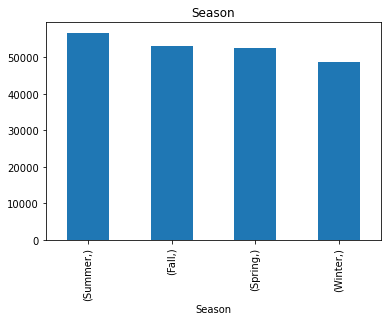

In [200]:
# Season variable
class SeasonTarnsformer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 # hardcoding these considering they don't change
                 winter: tuple = (354, 77), 
                 spring: tuple  = (78, 170),
                 summer: tuple = (171, 264),
                 fall: tuple = (265, 353)):
        # these could be included in a config file rather than hardcoded
        self.winter = winter
        self.spring = spring
        self.summer = summer
        self.fall = fall
        
        
    def fit(self, X: pd.DataFrame, y:pd.DataFrame = None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X.loc[(X['occurrencedayofyear'] >= self.winter[1]) |
               (X['occurrencedayofyear'] <= self.winter[0]), 'Season'] = 'Winter'
       
        X.loc[(X['occurrencedayofyear'] >= self.spring[0]) & 
              (X['occurrencedayofyear'] <= self.spring[1]), 'Season'] = 'Spring'
       
        X.loc[(X['occurrencedayofyear'] >= self.summer[0]) &
              (X['occurrencedayofyear'] <= self.summer[1]), 'Season'] = 'Summer'
       
        X.loc[(X['occurrencedayofyear'] >= self.fall[0]) &
              (X['occurrencedayofyear'] <= self.fall[1]), 'Season'] = 'Fall'        
        return X
st = SeasonTarnsformer()

# while this transformer is inteded to only transform and return X for purposes of integration
# into the pipeline, it also works with the entire dataframe which we'll use here for simplicity
features = st.transform(features)

features[["Season"]].value_counts().plot.bar(title="Season")

#### Adding weekends/ weekdays

<AxesSubplot:title={'center':'Weekday/Weekend'}, xlabel='Weekday/Weekend'>

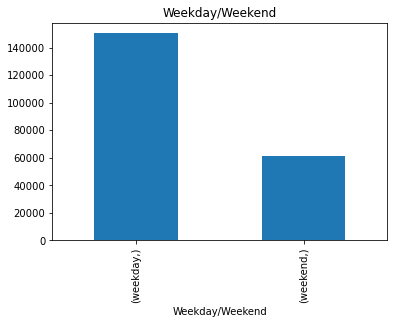

In [201]:
# Weekday/weekend variable

class WeekdayTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y:pd.DataFrame = None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X.loc[(X['occurrencedayofweek'] == 'Sunday') |
               (X['occurrencedayofweek'] == 'Saturday'), 'Weekday/Weekend'] = 'weekend'
        
        X.loc[(X['occurrencedayofweek'] != 'Sunday') &
                 (X['occurrencedayofweek'] != 'Saturday'), 'Weekday/Weekend'] = 'weekday'    
        return X

wt = WeekdayTransformer()
features = wt.transform(features)
features[["Weekday/Weekend"]].value_counts().plot.bar(title="Weekday/Weekend")

In [202]:
features[["Weekday/Weekend"]].value_counts()

Weekday/Weekend
weekday            150396
weekend             60910
dtype: int64

#### Binning crime occurence according to level:

<AxesSubplot:xlabel='occurrencehour'>

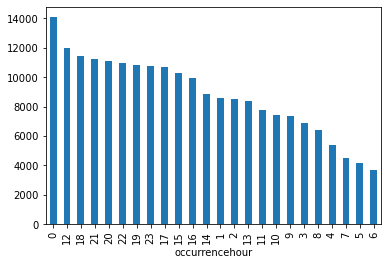

In [203]:
sorted_crime_count = features.groupby("occurrencehour").count()["occurrencedayofyear"].sort_values(ascending= False)
sorted_crime_count.plot.bar()

In [204]:
sorted_crime_count = features.groupby("occurrencehour").count()["occurrencedayofyear"].sort_values(ascending= False)
sorted_crime_count.index

Int64Index([ 0, 12, 18, 21, 20, 22, 19, 23, 17, 15, 16, 14,  1,  2, 13, 11, 10,
             9,  3,  8,  4,  7,  5,  6],
           dtype='int64', name='occurrencehour')

In [205]:
# these will go into a confiuration file for use in the pipeline
LEVELS = {
        "HIGH":list(sorted_crime_count[:10].index),
        "MED": list(sorted_crime_count[10:-4].index),
        "LOW": list(sorted_crime_count[-4:].index)
        }

<AxesSubplot:title={'center':'ToD Crime Level'}, xlabel='ToDCrimeLevel'>

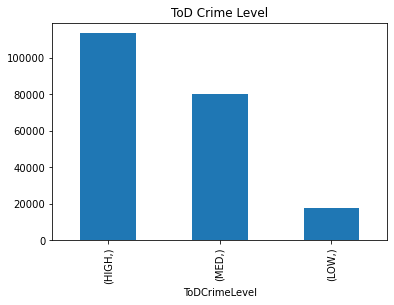

In [206]:
# Group crime commission levels (low, medium, high) according to time of day intervals:

class ToDTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, levels: dict):
        if (not isinstance(levels, dict) or not all([isinstance(level, list) 
                                                     for level in levels.values()])):
            raise ValueError('levels should be a dictionary of key[string]: value[list] pairs')
        self.levels = levels
        
    def fit(self, X: pd.DataFrame, y:pd.DataFrame = None):  
        return self
    
    def transform(self, X: pd.DataFrame):
        for key, values in zip(self.levels.keys(), self.levels.values()):
            X.loc[X['occurrencehour'].isin(values), "ToDCrimeLevel"] = key
            
        return X

tod = ToDTransformer(levels=LEVELS)
features = tod.transform(features)

features[["ToDCrimeLevel"]].value_counts().plot.bar(title="ToD Crime Level")

#### Adding Ontario holidays

Holiday    
non-holiday    205140
holiday          6166
dtype: int64

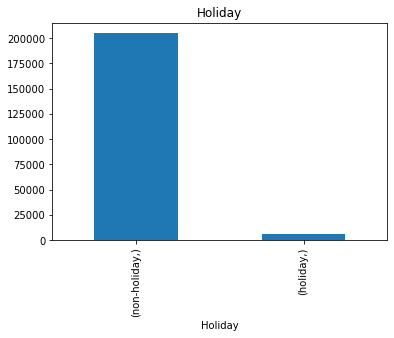

In [207]:
# New year, family day, good friday, victoria day, canada day, labour day, thanksgiving, christmas, boxing day (Ontaio)
ONTARIO_HOLIDAYS = [1, 46, 92, 144, 182, 249, 284, 359, 360]

class HolidayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, holidays):
        if (not isinstance(holidays, list) or not all([isinstance(element, int) 
                                                     for element in holidays])):
            raise ValueError('holidays should be a list of integers')
        self.holidays = holidays
        
    def fit(self, X: pd.DataFrame, y:pd.DataFrame = None):
        return self
    
    def transform(self, X:pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X['Holiday'] = X['occurrencedayofyear'].apply(lambda i: 'holiday' if i in self.holidays else 'non-holiday')
        return X
    
ht = HolidayTransformer(holidays=ONTARIO_HOLIDAYS)
features = ht.transform(features)

features[["Holiday"]].value_counts().plot.bar(title="Holiday")
display(features[["Holiday"]].value_counts())

In [208]:
# Check for null values in engineered variables

features["Season"].isna().sum(), features["Season"].value_counts().sum()
features["Weekday/Weekend"].isna().sum(), features["Weekday/Weekend"].value_counts().sum()
features["ToDCrimeLevel"].isna().sum(), features["ToDCrimeLevel"].value_counts().sum()
features["Holiday"].isna().sum(), features["Holiday"].value_counts().sum()

(0, 211306)

In [209]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211306 entries, 0 to 211365
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   occurrencehour       211306 non-null  int64  
 1   premises_type        211306 non-null  object 
 2   occurrencemonth      211306 non-null  object 
 3   occurrencedayofweek  211306 non-null  object 
 4   MCI                  211306 non-null  object 
 5   Neighbourhood        211306 non-null  object 
 6   occurrenceday        211306 non-null  float64
 7   occurrencedayofyear  211306 non-null  float64
 8   Season               211306 non-null  object 
 9   Weekday/Weekend      211306 non-null  object 
 10  ToDCrimeLevel        211306 non-null  object 
 11  Holiday              211306 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 29.0+ MB


In short, certain features exhibit imbalances, some of which are more extreme than others; we also observe seasonality and varying crime levels through out the day. For example we can look at:
- crimes committed during holidays: 6166 / 9 = 680 / day
- crimes committed during non-holidays: 205140 / (365-9) = 573 / day, 

indicating a greater level of crime commission during the holidays - correlation not causality!

Altrnatively, we can look at:

- ratio of crimes committed during weekdays vs weekends: (150396 / 5) / (60910 / 2)= 29894 / 30304 =  0.98,

indicating a slightly lower crime rate during weekdays

## Objective 1

At this point we pursue two objectives. One, to predict crime location prediction based on the existing features and the ones we've engineered. Two, by collected extra data to augment our set of features.

Encoding

In [210]:
features[features.isnull()].count()

occurrencehour         0
premises_type          0
occurrencemonth        0
occurrencedayofweek    0
MCI                    0
Neighbourhood          0
occurrenceday          0
occurrencedayofyear    0
Season                 0
Weekday/Weekend        0
ToDCrimeLevel          0
Holiday                0
dtype: int64

In [211]:
# to add to the config for pipeline
CAT_VARS = features.columns 

In [154]:
CAT_VARS

Index(['occurrencehour', 'premises_type', 'occurrencemonth',
       'occurrencedayofweek', 'MCI', 'Neighbourhood', 'occurrenceday',
       'occurrencedayofyear', 'Season', 'Weekday/Weekend', 'ToDCrimeLevel',
       'Holiday'],
      dtype='object')

In [212]:
# put all dummies and Long/Lat in one DataFrame for train-test splits
from sklearn.preprocessing import OneHotEncoder
import pickle


ohe = OneHotEncoder()
ohe.fit(X=features)
features = ohe.transform(features)

# we'll save out our encoder to simulate inference during deployment later on 
# with open("OHE", "wb") as f: 
#     pickle.dump(ohe, f)
#     f.close()

# we'll load it later on as follows then onduct some inference:
# with open("OHE", "rb") as f: 
#     OHE = pickle.load(f)
#     OHE.transform(features)

In [213]:
features

<211306x603 sparse matrix of type '<class 'numpy.float64'>'
	with 2535672 stored elements in Compressed Sparse Row format>

#### Training and testing

In [105]:
# split dataset into training dataset and testing dataset
X_train, X_test, y_train, y_test = train_test_split(features,targets.values,test_size =0.25, shuffle = True)

In [106]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((157762, 609), (52588, 609), (157762, 2), (52588, 2))

Given the significant number of feature dimensions, PCA will prove useful in identifying the most relevant features.

Let's train and test out linear models.

**NOTE**: for training and testing we utilize *RMSE* and *Euclidean* distances to gauge the accuracy of our predictions, but at the end we'll demonstrate the use of the *Haversine distance* to more realistically represent the distances between the actual crime loations and our predictions and the resulting error.

##### 1. Linear Regressor

In [ ]:
linr_start = time.time() # keep start time to compute elapsed time

#create pipeline
linr_pipe = Pipeline([('select', PCA()),
                    ('linr', LinearRegression())])

# set parameters for GridSearch
linr_params = {
             'select__n_components':[.90,.95],
             'linr__fit_intercept':[True,False], 
             'linr__normalize':[True,False]
            }

# run GridSearchCV to find the best setting of parameters  
linr_reg = GridSearchCV(linr_pipe, linr_params, scoring='neg_mean_squared_error',
                        n_jobs=2, refit=True, cv=3, verbose=True, return_train_score=True)

#train the model
linr_reg.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  2.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('select', PCA()),
                                       ('linr', LinearRegression())]),
             n_jobs=2,
             param_grid={'linr__fit_intercept': [True, False],
                         'linr__normalize': [True, False],
                         'select__n_components': [0.9, 0.95]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [ ]:
# show  parameters of the best model for linear regressor
print('Best Score of Linear Regressor: ',linr_reg.best_params_) 

# compute elapsed time
linr_end = time.time() 
linr_elapsed_time = linr_end - linr_start  

{'linr__fit_intercept': True,
 'linr__normalize': True,
 'select__n_components': 0.95}

In [ ]:
# create a function to calculate rmse, mean of errors and standard deviation of errors
def cal_rmse_mean_std_error (y_test, y_predit):
    "get two datasets of y_test and y_predict (shape of input is (xxx,2))"
    "calculate euclidean distance, means of distance errors, and std of distance errors"
    "Then, return these values"
    #compute root mean squared error of predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_predit))
    
    # compute meand and std of euclidean distance 
    euclidean_dist = ((y_test - y_predit)['X']**2 + (y_test - y_predit)['X']**2)**0.5
    mean_error = euclidean_dist.mean()
    std_error = euclidean_dist.std()
    
    return rmse, mean_error, std_error

In [ ]:
from sklearn.metrics import mean_squared_error

# prdict lat and long for X_trian
linr_y_tr_pred = linr_reg.predict(X_train)
linr_tr_rmse =(mean_squared_error(linr_y_tr_pred,y_train))**0.5
print('Training Data: Linear RMSE:{:.2f}'.format(linr_tr_rmse)) # show RMSE of training data

# predict lat and long
linr_y_pred = linr_reg.predict(X_test)

#compute rmse, mean of distance errors, and standard deviation of distance errors 
linr_rmse, linr_dist_mean_error, linr_dist_std =  cal_rmse_mean_std_error (y_test, linr_y_pred)

print('Testing Data: Linear RMSE {:.2f}'.format(linr_rmse),'Mean errors of Euclidean Distance: {:.2f}'.format(linr_dist_mean_error),
      'Standard deviation of Euclidean Distance: {:.2f}'.format(linr_dist_std))

Training Data: Linear RMSE:1087.81
Testing Data: Linear RMSE 1086.87 Mean errors of Euclidean Distance: 1136.17 Standard deviation of Euclidean Distance: 1035.09


RMSE of testing data is insignificantly different from RMFE of training data, meaning that this model is not overfitting

In [140]:
# keep reg_name, rmse, mean and std of Euclidean_dist, best score, and elapsed time for further analysis
reg_name.append('Linear')
result_rmse.append(linr_rmse)
result_elu_mean.append(linr_dist_mean_error)
result_elu_std.append(linr_dist_std)
result_elapsed_time.append(linr_elapsed_time/60) #convert sec to min

##### 2. Elastic Net Regressor

In [404]:
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet

EN_start = time.time() # keep start time to cumpute elapsed time

# construct a pipeline
EN_pipe = Pipeline([('select', PCA()),
                    ('EN', MultiOutputRegressor(ElasticNet()))])

# set parameters for GridSearch
EN_params = {
              'select__n_components':[.90,.95],
              'EN__estimator__alpha':np.logspace(0,3, num=4),
              'EN__estimator__l1_ratio':[0,0.4,0.8,1.0],
              'EN__estimator__fit_intercept': [True,False],
              'EN__estimator__normalize':[True,False]
             }

# run GridSearchCV to find the best setting of parameters    
EN_reg = GridSearchCV(EN_pipe, EN_params,  scoring='neg_mean_squared_error',
                      n_jobs=2, refit=True, cv=3, verbose=True, return_train_score=True)
#train the model
EN_reg.fit(X_train,y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 11.3min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 48.3min
[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed: 89.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('select', PCA()),
                                       ('EN',
                                        MultiOutputRegressor(estimator=ElasticNet()))]),
             n_jobs=2,
             param_grid={'EN__estimator__alpha': array([   1.,   10.,  100., 1000.]),
                         'EN__estimator__fit_intercept': [True, False],
                         'EN__estimator__l1_ratio': [0, 0.4, 0.8, 1.0],
                         'EN__estimator__normalize': [True, False],
                         'select__n_components': [0.9, 0.95]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [ ]:
# show  parameters of the best model for EN regressor
print('Best Score of Elastic Net Regressor: ',EN_reg.best_params_) 

# calculate elapsed time
EN_end = time.time() 
EN_elapsed_time = EN_end - EN_start  

{'EN__estimator__alpha': 1.0,
 'EN__estimator__fit_intercept': True,
 'EN__estimator__l1_ratio': 1.0,
 'EN__estimator__normalize': False,
 'select__n_components': 0.95}

In [ ]:
# prdict lat and long for X_trian
EN_y_tr_pred = EN_reg.predict(X_train)
EN_tr_rmse =(mean_squared_error(EN_y_tr_pred,y_train))**0.5
print('Training Data: Elastic Net RMSE:{:.2f}'.format(EN_tr_rmse)) # show RMSE of training data

EN_y_pred = EN_reg.predict(X_test) # predict lat and long

#compute rmse, mean of distance errors, and standard deviation of distance errors 
EN_rmse, EN_dist_mean_error, EN_dist_std =  cal_rmse_mean_std_error (y_test, EN_y_pred)

#show results
print('Testing Data: Elastic Net RMSE: {:.2f}'.format(EN_rmse),'Mean errors of Euclidean Distance: {:.2f}'.format(EN_dist_mean_error),
      'Standard deviation of Euclidean Distance: {:.2f}'.format(EN_dist_std))

Training Data: Elastic Net RMSE:1111.61
Testing Data: Elastic Net RMSE: 1111.77 Mean errors of Euclidean Distance: 1160.79 Standard deviation of Euclidean Distance: 1071.73


In [ ]:
# keep reg_name, rmse, mean and std of Euclidean_dist, best score, and elapsed time for further analysis
reg_name.append('Elastic Net') 
result_rmse.append(EN_rmse)
result_elu_mean.append(EN_dist_mean_error)
result_elu_std.append(EN_dist_std)
result_elapsed_time.append(EN_elapsed_time/60) #convert sec to min

Let's test out non-linear models.

##### 3. XGB Regressor

In [4]:
from xgboost.sklearn import XGBRegressor

XGB_start = time.time() # keep start time to cumpute elapsed time

# construct a pipeline
XGB_pipe = Pipeline([('select', PCA()),
                    ('XGB', MultiOutputRegressor(XGBRegressor(tree_method='gpu_hist', 
                      gpu_id=0,objective='reg:linear',nthread=4,predictor='gpu_predictor')))])


# set parameters for GridSearch
XGB_params = {
              'select__n_components':[.90,.95],
              'XGB__estimator__learning_rate': [0.05, 0.1, 0.4, 0.7], #so called `eta` value
              'XGB__estimator__max_depth': [2, 3, 4, 5],
              'XGB__estimator__n_estimators': [400,600,800]
             }

# run GridSearch to find the best  parameters    
XGB_reg = GridSearchCV(XGB_pipe, XGB_params,  scoring='neg_mean_squared_error',
                      n_jobs=2, refit=True, cv=3, verbose=True, return_train_score=True)
# train the model
XGB_reg.fit(X_train,y_train)

In [ ]:
# show  parameters of the best model for XGB regressor
print('Best Score of XGB Regressor: ', XGB_reg.best_params_ ) 

# calculate elapsed time
XGB_end = time.time() 
XGB_elapsed_time = XGB_end - XGB_start 

{'XGB__estimator__learning_rate': 0.1,
 'XGB__estimator__max_depth': 5,
 'XGB__estimator__n_estimators': 800,
 'XGB__estimator__predictor': 'gpu_predictor',
 'select__n_components': 0.9}

In [ ]:
# prdict lat and long for X_trian
XGB_y_tr_pred = XGB_reg.predict(X_train)
XGB_tr_rmse =(mean_squared_error(XGB_y_tr_pred,y_train))**0.5

print('Training Data: XGB RMSE{:.2f}'.format(XGB_tr_rmse)) # show RMSE of training data

# predict lat and long
XGB_y_pred = XGB_reg.predict(X_test)

#compute rmse, mean of distance errors, and standard deviation of distance errors 
XGB_rmse, XGB_dist_mean_error, XGB_dist_std =  cal_rmse_mean_std_error (y_test, XGB_y_pred)

#show results
print('Testing Data: XGB RMSE {:.2f}'.format(XGB_rmse),'Mean errors of Euclidean Distance: {:.2f}'.format(XGB_dist_mean_error),
      'Standard deviation of Euclidean Distance: {:.2f}'.format(XGB_dist_std))

Training Data: XGB RMSE990.79
Testing Data: XGB RMSE 1101.80 Mean errors of Euclidean Distance: 1135.40 Standard deviation of Euclidean Distance: 1064.76


In [ ]:
# keep reg_name, rmse, mean and std of Euclidean_dist for further analysis
reg_name.append('XGB') 
result_rmse.append(XGB_rmse)
result_elu_mean.append(XGB_dist_mean_error)
result_elu_std.append(XGB_dist_std)
result_elapsed_time.append(XGB_elapsed_time/60) #convert sec to min

##### 4. Voting Regressor 

We can try a voting regressor that will combine various models and utilize the optimal parameters for each estimator as established above

In [ ]:
from sklearn.ensemble import VotingRegressor

VR_bm_start = time.time() # keep start time to cumpute elapsed time

# create best models manually: linear, Elastic Net, XGB
lr_best = LinearRegression(fit_intercept=True,normalize=True) 

EN_best = ElasticNet(alpha=1.0,fit_intercept=True,l1_ratio=1.0,normalize=False)

XGB_best = XGBRegressor(learning_rate=0.1,max_depth=5,n_estimators=800,nthread=4,
                       objective='reg:squarederror',predictor='gpu_predictor',tree_method='gpu_hist', gpu_id=0)

#Apply PCA =0.95 to X since 2 of 3 models get the better results when PCA = 0.95
## Assume PCE = 0.95 for Voting Regressor
pca = PCA(n_components=0.95, svd_solver='full') # let PCA find the number of features which explained_variance_ratio_ =0.95
pca.fit(X)
X_95 = pca.transform(X)
df_X_95 = pd.DataFrame(X_95)


# test dataset = 30%, shuffle = True since it's not time-series
## neeed to split X and y again so that the number of features of X_train is equal to that of X_test
X_train_95, X_test_95, y_train_95, y_test_95 = train_test_split(df_X_95,y,test_size =0.3, shuffle = True,random_state =42)


# combine the three models: linear, Elastic Net, XGB to constract voting regressor
VR_bm_reg = MultiOutputRegressor(VotingRegressor(estimators=[('lr', lr_best), ('EN', EN_best), ('XGB', XGB_best)]))

# fit data
VR_bm_reg.fit(X_train_95,y_train)

MultiOutputRegressor(estimator=VotingRegressor(estimators=[('lr',
                                                            LinearRegression(normalize=True)),
                                                           ('EN',
                                                            ElasticNet(l1_ratio=1.0)),
                                                           ('XGB',
                                                            XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         gamma=None,
                                                                    

In [ ]:
# calculate elapsed time
VR_bm_end = time.time() 
VR_bm_elapsed_time = VR_bm_end - VR_bm_start 

In [ ]:
# prdict lat and long for X_trian
VR_bm_y_tr_pred = VR_bm_reg.predict(X_train_95)
VR_bm_tr_rmse =(mean_squared_error(VR_bm_y_tr_pred,y_train))**0.5

print('Training Data: VR RMSE:{:.2f}'.format(VR_bm_tr_rmse)) # show RMSE of training data

# predict lat and long
VR_bm_y_pred = VR_bm_reg.predict(X_test_95)

#compute rmse, mean of distance errors, and standard deviation of distance errors 
VR_bm_rmse, VR_bm_dist_mean_error, VR_bm_dist_std =  cal_rmse_mean_std_error (y_test, VR_bm_y_pred)

#show results
print('Testing Data: VR RMSE: {:.2f}'.format(VR_bm_rmse),'Mean errors of Euclidean Distance: {:.2f}'.format(VR_bm_dist_mean_error),
      'Standard deviation of Euclidean Distance: {:.2f}'.format(VR_bm_dist_std))

Training Data: VR RMSE:1021.86
Testing Data: VR RMSE: 1057.32 Mean errors of Euclidean Distance: 1094.61 Standard deviation of Euclidean Distance: 1007.38


In [ ]:
# keep reg_name, rmse, mean and std of Euclidean_dist for further analysis
reg_name.append('Voting') 
result_rmse.append(VR_bm_rmse)
result_elu_mean.append(VR_bm_dist_mean_error)
result_elu_std.append(VR_bm_dist_std)


# we run grid search to find the best parameters and then using the best parameters to create models, so we should include
## elpased time for training three models
VR_elapsed_time_total =  linr_elapsed_time + EN_elapsed_time + XGB_elapsed_time + VR_bm_elapsed_time

result_elapsed_time.append(VR_elapsed_time_total/60) #convert sec to min

#### Results

In [ ]:
# create dataframe to show result
result = pd.DataFrame(list(zip(reg_name, result_rmse,result_elu_mean,result_elu_std,result_elapsed_time)),
               columns =['Regressor Name', 'RMSE','Mean Error','SD','Elapsed Time (min)'])

result=result.round(1) # round values to be 1 decimal
result.head()

Regressor Name    RMSE  Mean Error      SD  Elapsed Time (min)
0         Linear  1086.9      1136.2  1035.1                 2.4
1    Elastic Net  1111.8      1160.8  1071.7                89.4
2            XGB  1101.8      1135.4  1064.8               127.3
3         Voting  1057.3      1094.6  1007.4               220.5

Text(0.5, 0, 'Regressor Name')

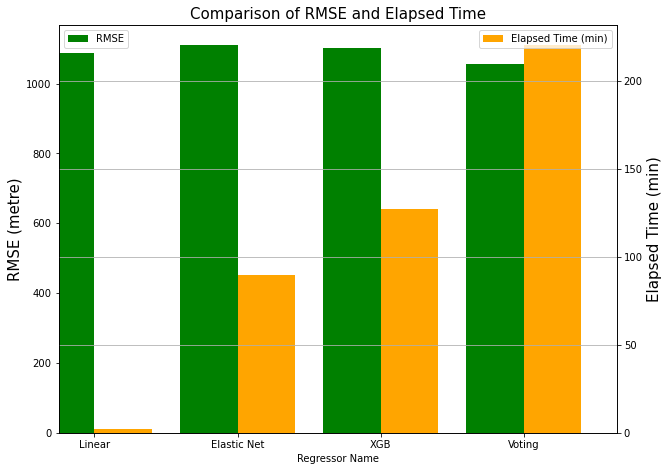

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

# plot RMSE and Elapsed Time
ax = result.plot(x='Regressor Name',y='RMSE',kind='bar',figsize=(10,7.5), color='green', ax=ax, width=0.4 ,position=1,rot =0,fontsize =10)
ax2 = result.plot(x='Regressor Name',y='Elapsed Time (min)',kind='bar',figsize=(10,7.5), color='orange'
                  , ax=ax2, width=0.4, position=0,rot=0,fontsize =10)

ax.set_ylabel('RMSE (metre)', fontsize = 15)
ax2.set_ylabel('Elapsed Time (min)', fontsize = 15)

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()
plt.title('Comparison of RMSE and Elapsed Time', fontsize = 15)
plt.xlabel('Regressor Name',fontsize =15)

<ErrorbarContainer object of 3 artists>

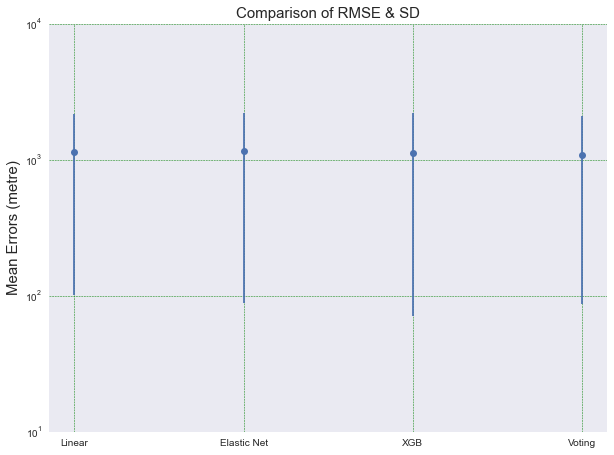

In [ ]:
#show mean errors with std
fig = plt.figure(figsize=(10,7.5))

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.yscale('log')
plt.ylim(10, 10**4)
plt.ylabel ('Mean Errors (metre)', fontsize = 15)
plt.title('Comparison of RMSE & SD', fontsize = 15)
plt.errorbar(result['Regressor Name'],result['Mean Error'], result['SD'], linestyle='None', marker='o')

#### Prediction


In [ ]:
# choose data we want to predict X and Y from event_unique_id
df_predict = unique_data.query('event_unique_id in ["GO-20161131520","GO-20201286477","GO-2017318380","GO-2015221810","GO-20191249125","GO-20202246163"]')
df_predict[['X','Y','event_unique_id']]

# according to this table, list of index = [31633,33219,34336,113462,117692,119444]

X             Y event_unique_id
31633  -8.851696e+06  5.428352e+06  GO-20161131520
33219  -8.852404e+06  5.429531e+06  GO-20201286477
34336  -8.851579e+06  5.426388e+06   GO-2017318380
113462 -8.837708e+06  5.410670e+06   GO-2015221810
117692 -8.839123e+06  5.410698e+06  GO-20191249125
119444 -8.838855e+06  5.410561e+06  GO-20202246163

The above results can be divided by 111,139 to get the equivalent lat/long coordiantes in degrees.

In [ ]:
list_idx = [31633,33219,34336,113462,117692,119444] # list of index for predicting X and Y

list_reg = [VR_bm_reg] # regressor to predict X and Y
reg_name = ['Voting'] # regressor name to predict X and Y
result = np.zeros((len(list_idx),len(list_reg))).astype('str') # create string array to keep predictions

for a, reg in enumerate(list_reg):

    for b, idx in enumerate(list_idx):
        if (reg==VR_bm_reg):
            temp_df =pd.DataFrame(df_X_95.iloc[idx,:]).transpose()
        else:
            temp_df =pd.DataFrame(X.iloc[idx,:]).transpose()
            
        temp_y_pred = reg.predict(temp_df).round(0) # predict X,Y and then round to 0 decimal
        result[b,a]= str(temp_y_pred[0]) # keep prediction in string array

df_result = pd.DataFrame(result, columns=reg_name, index=list_idx) # create result dataframe
df_result

Voting
31633   [-8852102.  5429018.]
33219   [-8851963.  5429034.]
34336   [-8851465.  5426384.]
113462  [-8837676.  5410392.]
117692  [-8837438.  5410548.]
119444  [-8837277.  5410602.]

The above results can be divided by 111,139 to get the equivalent lat/long coordiantes in degrees.

#### Learning Curves

In [402]:
# Considering learning curves are not part of the model and parameters to be exported, 
# they are visualized independent of the pipeline to be exported

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(X_data, y_data, estimator, y_lim_up, y_lim_down, train_sizes, title: str):
    """
    Plots a learning curve given assumptions: PCA maintains 95% explained variance, train-test split 70:30, CV Folds =3, scoring: negative RMSE
    """
    # PCA
    pca = PCA(n_components=0.95, svd_solver='full') # let PCA find the numbe of features which explained_variance_ratio_ =0.95
    pca.fit(X_data)
    X_95 = pca.transform(X_data)

    # Train-tst split
    X_train, X_test, y_train, y_test = train_test_split(X_95, y_data,test_size =0.3, shuffle = True,random_state =42)
    
    # Train/Validate
    train_sizes, train_scores, validation_scores = learning_curve(estimator=estimator,
                                                                  X = X_train,
                                                                  y = y_train, train_sizes = train_sizes, cv = 3,
                                                                  scoring = 'neg_root_mean_squared_error')

    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    # Plot
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training Curve')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation Curve')
    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('{}'.format(title), fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(y_lim_down, y_lim_up)

In [ ]:
train_sizes = [1000, 2000, 4000, 7000, 10000, 20000, 4000, 60000, 90000]
y_lim_down = 600
y_lim_up = 2000

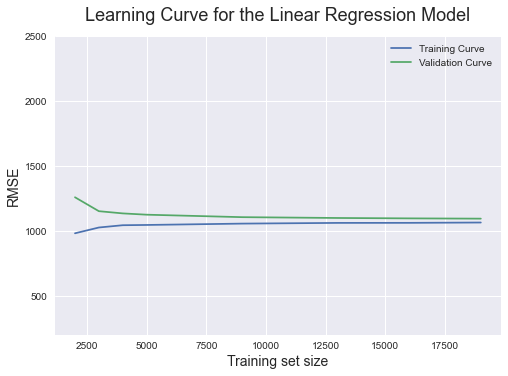

In [ ]:
# Learning Curve for the Linear Regression Model
LinReg =lr_best
plot_learning_curve(X, y, LinReg, y_lim_up, y_lim_down, train_sizes, "Learning Curve for the Linear Regression Model")

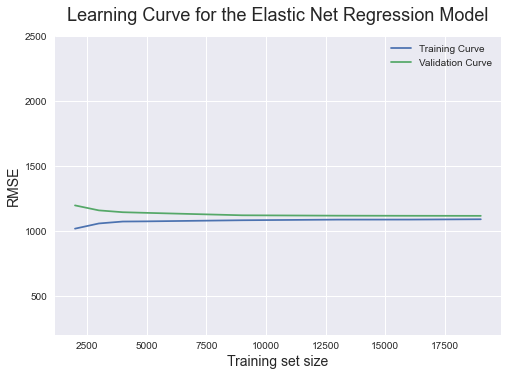

In [ ]:
# Learning Curve for the Elastic Net Regression Model
EL_net = EN_best
plot_learning_curve(X, y, EL_net, y_lim_up, y_lim_down, train_sizes, "Learning Curve for the Elastic Net Regression Model")

In [141]:
# ------ requires debugging
# Learning Curve for the XGB Regression Model"

## create XGB regressor with best parameters from hyperparameter-tuning
XGB_best = MultiOutputRegressor(XGBRegressor(learning_rate=0.1,max_depth=5,n_estimators=800,nthread=4,
                       objective='reg:squarederror',predictor='gpu_predictor',tree_method='gpu_hist', gpu_id=0))

train_sets = [2000, 3000, 4000, 5000, 9000, 13000, 16000, 19000]
XGB_reg = XGB_best
y_lim_up = 2500
y_lim_down = 200
train_sizes=train_sets
plot_learning_curve(X, y, XGB_reg,y_lim_up, y_lim_down, train_sizes,"Learning Curve for the XGB Regression Model")

## Objective 2

This part of the feature engineering steps involves collecting/scraping data from other sources to link it to the Toronto Police MCI data set.

I've scraped for locations of pubs, parks, and police station which are locations that MAY influence the level of crime in the area.

The following data was collected:

- 406 pub locations in the 6 Toronto adminsitrative regions (their identity is anonymized)
- 93 locations park " " " " " "
- 23 police stations " " " " " "

...

In [1]:
import os
import json

os.environ['PYTHONHASHSEED'] = '0'

In [2]:
import json

In [3]:
# to be included in the config
ADDED_FEATURE_NAMES = ["Pub_Id","Park_Id","PS_Id"]

added_features = [json.load(open(name+".json"))
                            for name in ADDED_FEATURE_NAMES]

Let's checkout the locations we collected

In [42]:
import folium

geo_data_sample_pubs = pd.DataFrame(added_features[0]).set_index(ADDED_FEATURE_NAMES[0])
geo_data_sample_parks = pd.DataFrame(added_features[1]).set_index(ADDED_FEATURE_NAMES[1])
geo_data_sample_PS = pd.DataFrame(added_features[2]).set_index(ADDED_FEATURE_NAMES[2])

geo_data = [geo_data_sample_parks, geo_data_sample_PS, geo_data_sample_pubs]
colours = ["blue", "black", "yellow"]
map5 = folium.Map(prefer_canvas=True)

for feature, colour in zip(geo_data, colours):
    feature.apply(plotDot, 
            lat=feature.columns[0], 
            long=feature.columns[1],
            axis = 1, 
            cc=False, 
            colour=colour, 
            map=map5)
map5.fit_bounds(map5.get_bounds())
map5

To tie crime location to these locations we need to minimize the distance between the two. 

This means iterating through each crime location, say M, and minimizing the Euclidean distance to each location, N. This involves sum(M x N(M)) total operations. 

______________________________________
__________________

To integrate the collected data into our dataset, each crime record will be mapped to the closest pub, park and polie station loation.

This is done to the entire dataset.

The question that arises is: *is this leaking information to the test set when it is sliced from the entire dataset in the following steps?*

The answer is that it doesn't since the TPD will query locations the various locations of pubs, parks and and police stations, along with the other features and get predicted locations based on those. 

Put differently, the TPD is expected to query around 600 total critical locations for every time interval it desires and use the resulting prediction to assign units to locations where predictions are clustered.

In this way, there is no real leak of information to the would-be test set. Instead the complexity of the model is increased by incoporating the newly collected features.

In [182]:
INT_COLS = ['occurrencehour']
CAT_COLS = ['premises_type',
          'occurrencemonth',
           'event_unique_id',
          'occurrencedayofweek',
          'MCI',
          'Neighbourhood']
FLOAT_COLS = [
  'occurrenceday',
  'occurrencedayofyear',
  'Long',
  'Lat']
OHE_COLS = INT_COLS + FLOAT_COLS + FLOAT_COLS

CRIME_COUNT = [ 0, 12, 18, 21, 20, 22, 19, 23, 17, 15, 16, 14,  1,  2, 13, 11, 10,
             9,  3,  8,  4,  7,  5,  6]
LEVELS = {
        "HIGH":list(CRIME_COUNT[:10]),
        "MED": list(CRIME_COUNT[10:-4]),
        "LOW": list(CRIME_COUNT[-4:])
        }

ONTARIO_HOLIDAYS = [1, 46, 92, 144, 182, 249, 284, 359, 360]

In [149]:
data = pd.read_csv('Major_Crime_Indicators.csv')

features = data[INT_COLS + CAT_COLS + FLOAT_COLS[:-2]]
targets =  data[FLOAT_COLS[-2:]]

C:\Users\Moham\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [150]:
import transformers as t

replaceNSA = t.ReplaceNSA()
fitted_replacer = replaceNSA.fit(X=features, y=targets)
features = fitted_replacer.transform(features)

C:\Users\Moham\_Toronto Police MCI\transformers.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.nsa_column][index] = self.cluster_centres.index[shortest_idx]


In [151]:
class NewFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features: list[object], feature_names: list[str]):
        self.features = features
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y):
        # we use numpy arrays instead of dataframes given the intesity of the transformations
        target = y.copy().reindex(columns=["Lat", "Long"]).values
        X = X.copy()
        for feature, name in zip(self.features, self.feature_names):
            
            source = pd.DataFrame(feature).set_index(name).values
            new_col = list()
            for x in range(len(target)):
                distances = []
                for y in range(len(source)):
                    distance = ((source[y,0] - target[x,0])**2 + (source[y,1] - target[x,1])**2)**0.5
                    distances.append(distance)
                new_col.append(distances.index(min(distances)))    
            X[name] = 0
            X[name] = new_col
        
        return X

In [152]:
nft = NewFeatureTransformer(features= added_features, feature_names= ADDED_FEATURE_NAMES)
features_ = nft.transform(X=features, y=targets)

In [153]:
features_[ADDED_FEATURE_NAMES].value_counts()

Pub_Id  Park_Id  PS_Id
252     83       19       7290
253     59       19       3808
255     82       19       3109
233     82       21       2845
371     83       19       2691
                          ... 
299     80       11          1
57      76       10          1
233     90       19          1
52      39       1           1
190     58       14          1
Length: 933, dtype: int64

In [154]:
# we'll save the raw data set with the new features for use in the train/prediction pipelines
pd.concat([features_,targets], axis=1).to_csv("raw_data_plus_new_features.csv")

In [187]:
data = pd.read_csv("raw_data_plus_new_features.csv")

In [188]:
data.drop(columns="Unnamed: 0", inplace = True)

Carrying on with cleaning, feature engineering & transformation and then fitting.

In [189]:
data = data.drop_duplicates(subset=['event_unique_id']).reset_index()
data.dropna(axis=0, inplace=True)

In [190]:
data.columns

Index(['index', 'occurrencehour', 'premises_type', 'occurrencemonth',
       'event_unique_id', 'occurrencedayofweek', 'MCI', 'Neighbourhood',
       'occurrenceday', 'occurrencedayofyear', 'Pub_Id', 'Park_Id', 'PS_Id',
       'Long', 'Lat'],
      dtype='object')

In [191]:
INT_COLS = ['occurrencehour', 'Pub_Id', 'Park_Id', 'PS_Id']
features = data[INT_COLS + CAT_COLS + FLOAT_COLS[:-2]]
features.drop(columns="event_unique_id", inplace = True)
targets =  data[FLOAT_COLS[-2:]]

In [192]:
data.isna().sum().sum()

0

In [193]:
features = t.SeasonTarnsformer().fit_transform(X=features)
features = t.WeekdayTransformer().fit_transform(X=features)
features = t.ToDTransformer(levels=LEVELS).fit_transform(X=features)

In [194]:
features.columns

Index(['occurrencehour', 'Pub_Id', 'Park_Id', 'PS_Id', 'premises_type',
       'occurrencemonth', 'occurrencedayofweek', 'MCI', 'Neighbourhood',
       'occurrenceday', 'occurrencedayofyear', 'Season', 'Weekday/Weekend',
       'ToDCrimeLevel'],
      dtype='object')

After encoding the added features, we can expect a significant increase in dimensionality at which point PCA would become essential in reducing unecessary dimensions that don't have a bearing on crime location prediction

In [195]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit(features)
features = ohe.transform(features)



# # we'll save out our encoder to simulate inference during deployment later on 
# with open("OHE_2.pkl", "wb") as f: 
#     pickle.dump(ohe, f)
#     f.close()

# we'll load it later on as follows then onduct some inference:
# with open("OHE_2", "rb") as f: 
#     OHE = pickle.load(f)
#     OHE.transform(features)

In [198]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, svd_solver='full') # let PCA find the numbe of features which explained_variance_ratio_ =0.95
pca.fit(features)
# pickle.dump(pca, open("PCA.pkl","wb"))
features_95 = pca.transform(features)

In [199]:
features_95.shape

(211306, 566)

We've managed to maintain 95% variability in our features while reducing the dimnesionality of our data by just over half the number of features.

In [200]:
# split dataset into training dataset and testing dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_95,targets.values,test_size =0.25, shuffle = True)

In [201]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((158479, 566), (158479, 2), (52827, 566), (52827, 2))

### Training and testing

We'll use the optimal parameters from the previous models assuming they're still the optimal parameters after adding the geospatial features.

In [203]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(n_jobs=2)
lr = lr.fit(X_train, y_train)
# Check out the R squared score
lr.score(X_test, y_test)

0.978682314703593

- The high R^2 is explained by the presence of the neighbourhood feature which narrows down the search to an area of, say, 20-30 KM squared in which the police department is trying to predict the crime. 

- It is not unusual for a police department to start off by specifying districts and neighbourhoods if it wanted to predict crime hotspots in order to direct the closest units to it given the police force consists of hundreds, if not thousands, of units on the field patrolling various neighbourhoods, within their operating ward.  

In [204]:
# from sklearn.metrics import mean_squared_error
preds = lr.predict(X_test)
error_in_meters = ((((preds[:, 0] - y_test[:, 0])**2 + (preds[:, 1] - y_test[:, 1])**2)**0.5).mean())  * 111139
print(f"The average prediction error is {error_in_meters} meters off the actual crime location.")

The average prediction error is 968.5973146075156 meters off the actual crime location.


In [205]:
pickle.dump(lr, open("LinearRegression.pickle.dat", "wb"))

Adding the location features that were scraped seems to be able to significatly improve accuracy from 1060 meters to 968 meters which doesn't seem like a major improvement given the increased feature complexity. Since we did improve our RMSE, however, it doesn't indicate that our added features were indeed useful, otherwise PCA "wouldn't have accomodated them".

What about a non-linear estimator?

In [206]:
# optimal XGBoost parameters from previous grid search
# {'XGB__estimator__learning_rate': 0.1,
#  'XGB__estimator__max_depth': 5,
#  'XGB__estimator__n_estimators': 800,
#  'XGB__estimator__predictor': 'gpu_predictor'}
import xgboost
from sklearn.multioutput import MultiOutputRegressor
model = xgboost.XGBRegressor(learning_rate=0.1,max_depth=5,n_estimators=800,nthread=11, objective='reg:squarederror')
XGB_best = MultiOutputRegressor(model)

In [208]:
XGB_best.fit(X_train, y_train)

In [247]:
# save XGBoost parameters to avoid retraining 
pickle.dump(XGB_best, open("XGBest.pickle.dat", "wb"))
loaded_model = pickle.load(open("XGBest.pickle.dat", "rb"))
preds = loaded_model.predict(X_test)

In [248]:
preds = loaded_model.predict(X_test)
error_in_meters = ((((preds[:, 0] - y_test[:, 0])**2 + (preds[:, 1] - y_test[:, 1])**2)**0.5).mean()) * 111139
print(f"The average prediction error is {error_in_meters} meters off the actual crime location.")

The average prediction error is 633.641701334048 meters off the actual crime location.


We notice XGBoost significantly outperforms the basic linear regression and ElasticNet regressions but a cost of increased computing requirements and ambiguity. The increase in the number of geospatial features will mean more complex ETL when streaming data and passing through for inference.

##### As a bonus, we can calculate accuracy using the Haversine distance:

In [252]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d*1000 #distance in meters

Make our predictions and evaluate Haversine distance

Linear regression

In [249]:
lr = LinearRegression(n_jobs=-1)
lr = lr.fit(X_train, y_train)
LR_preds = lr.predict(X_test)

In [253]:
data = pd.DataFrame(np.concatenate((LR_preds, y_test), axis=1, dtype="float32"))
data.columns = ["lat1","long1","lat2","long2"]
# data.head()
print("Crime locations predictions are about ", 
      haversine_distance(data, "lat1","long1","lat2", "long2").mean(),
      "meters off on average.")

Crime locations predictions are about  641.7784423828125 meters off on average.


XGBoost non-linear regression

In [257]:
loaded_model = pickle.load(open("XGBest.pickle.dat", "rb"))
XGB_preds = loaded_model.predict(X_test)

In [259]:
data = pd.DataFrame(np.concatenate((XGB_preds, y_test), axis=1, dtype="float32"))
data.columns = ["lat1","long1","lat2","long2"]
print("Crime locations predictions are about ", 
      haversine_distance(data, "lat1","long1","lat2", "long2").mean(),
      "meters off on average.")

Crime locations predictions are about  460.4170227050781 meters off on average.


The Haversine distance better captures the distances that are distinguishable only several loations after the decimal (100th or 10000th) and so may better demonstrate our prediction accuracy)

Overall, the added locations did improve crime location prediction accuracy. For inference purposes:
- the police department will need to feed the neighbourhood location of interest, time of day, day of the week, month of the year (these are expected to be converted to the engineered features through a data pipline) 
- the police department will need to feed the closest pub, park and police station locations based on the location of interest relevant to the locations or areas it wishes to make inference on.

## Inference

An inference pipeline to be used for testing

In [33]:
import os
import pandas as pd
import pickle

os.environ['PYTHONHASHSEED'] = '0'

In [34]:
data = pd.read_csv("Data_Ready for OHE_PCA")
data.drop(columns="Unnamed: 0", inplace=True)
feat = data.iloc[:,:-2]
targ = data.iloc[:,-2:]

# 1) Adjust to the intended number of samples
inference_sample = data[:10] 

# 2) Alternatively, make up data according to the following and set json=True:
inference_sample= {'premises_type': 'House',
                  'occurrencemonth': 'May',
                  'occurrenceday': 18.0,
                  'occurrencedayofyear': 138.0,
                  'occurrencedayofweek': 'Sunday',
                  'occurrencehour': 12,
                  'MCI': 'Assault',
                  'Neighbourhood': 'West Humber-Clairville (1)',
                  'Season': 'Spring',
                  'Weekday/Weekend': 'weekend',
                  'ToD Crime Level': 'high',
                  'Holiday/Non-Holiday': 'Non-Holiday',
                  'Pub_Id': 348,
                  'Park_Id': 83,
                  'PS_Id': 19}

In [35]:
# load transformers/ estiamtors
one_hot_ = pickle.load(open("OHE_2.pkl", "rb"))
pca_ = pickle.load(open("PCA.pkl", "rb"))
LR_ = pickle.load(open("LinearRegression.pickle.dat", "rb"))
XGB_ = pickle.load(open("XGBest.pickle.dat", "rb"))

In [36]:
def basic_inference_pipeline(data: object, cat_features: list, cont_features: list, # data
                             ohe: object, pca: object, # transformations
                             est: object, # inference 
                             dictionary: bool):
    '''
    Make predictions using arguments:
    data: your dataset object should be in a DataFrame/dictionary (JSON)
    cat/cont features: a list containing the name of your features (ex: list(data.keys()) | list(data.columns))
    ohe/pca/est: loaded pretrained ohe/pca/estiamtor objects
    dictionary: if data is imported as JSON
    '''
    
    if dictionary:
        data = pd.DataFrame(data)
    
    if cont_features and cat_features:
        cat_features = one_hot_.transform(data[cat_features])
        features = pd.concat((cat_features, data[cont_features]), axis=1)
    elif not cont_features:
        features = one_hot_.transform(data[cat_features]).toarray()
    else:
        features = data[cont_features]
    features = pca_.transform(features)
    predictions = model.predict(features)
    return predictions

In [38]:
lr_preds = basic_inference_pipeline(data= inference_sample, cat_features= list(inference_sample.columns)[:-2], cont_features= None,
                             ohe= one_hot_, pca= pca_, 
                             est=LR_, dictionary=False)


xgb_preds = basic_inference_pipeline(data= inference_sample, cat_features= list(inference_sample.columns)[:-2], cont_features= None,
                             ohe= one_hot_, pca= pca_, 
                             est=XGB_, dictionary=False)


squared_errors_LR = (lr_preds - inference_sample.iloc[:,-2:].values)**2
squared_errors_XGB = (xgb_preds - inference_sample.iloc[:,-2:].values)**2

LR_RMSE = ((squared_errors_LR.sum(axis=1))**0.5).mean()*111139
XGB_RMSE = ((squared_errors_XGB.sum(axis=1))**0.5).mean()*111139
print("Linear regression error: ", LR_RMSE," meters | XGB's error", XGB_RMSE," meters")

### Simulating deployment

Using Flask and Docker, the following scripts and text files can be used to containerize our prediction application and host it on a cloud VM service like on an AWS EC2instance.

<div class="alert alert-block alert-info">
The following files are used:
    
1. An application fie - app.py
    
2. A request (post request) file - request.py
    
3. A requirements file containing dependencies and version of our application - requirements.txt
    
4. Setup an amazon EC2 instance
    
5. Setup up Docker on the EC2 instance
    
6. Build a Docker image of our application using a Docker file - Dockerfile
    
</div>

#### app.py

In [1]:
import pickle
import numpy as np
from flask import Flask, request, jsonify
import os

os.environ['PYTHONHASHSEED'] = '0'

one_hot_ = None
pca_ = None
model = None
preds = None

app = Flask(__name__)

@app.route('/')
def home_endpoint():
    return 'Successfully hit home endpoint!'  # a message to indicate you've hit an endpoint meaning you can successsfully
                                              # requests to it

@app.route('/predict/', methods=['POST'])
def basic_inference_pipeline():
    data = request.get_json()
    
    # necessary transformations to ohe our features
    data = one_hot_.transform(np.array(data, dtype=np.object).reshape(1, -1)).toarray()
    data = pca_.transform(data)
    
    # necessary transformation to jsonify our predictions
    preds = np.array2string(model.predict(data))

    return jsonify(preds)


if __name__ == '__main__':  # call inference pipeline upon running script

    # assign ohe, pca transformer and predictive model objectives
    one_hot_ = pickle.load(open("OHE_2.pkl", "rb"))
    pca_ = pickle.load(open("PCA.pkl", "rb"))
    model = pickle.load(open("XGBest.pickle.dat", "rb"))
    app.run(host= '0.0.0.0', port=8000, debug=True)

#### request.py

In [ ]:
import json
import requests
import os

os.environ['PYTHONHASHSEED'] = '0'

# edit host/ip as required to post to the approriate server
server_url = 'http://34.207.84.210:8000/predict/' 

# edit query as required
data = json.dumps(['House', 'May', 18.0, 138.0, 'Sunday', 12, 'Assault', 'West Humber-Clairville (1)', 'Spring', 'weekend', 'high', 'Non-Holiday', 348, 83, 19])

request = requests.post(server_url, data, headers={"Content-type": "application/json"})
print(request, request.text)

#### requirements.txt

```
numpy==1.22.1
scipy==1.7.3
scikit-learn==1.0.2
xgboost==1.5.1
requests==2.22.0
requests-unixsocket==0.2.0
Flask==2.0.2
```

#### Dockerfile
This involves opying necessary files to a working directory for building our image: /deploy, including transformers, the estimator, the application, requirements and finally setting up the environment using the requirements file. This application is accessed through the necessary port and can be run through the entrypoint.

```
FROM python:3.8
WORKDIR /deploy/

COPY ./OHE_2.pkl /deploy/
COPY ./PCA.pkl /deploy/
COPY ./XGBest.pickle.dat /deploy/

COPY ./app.py /deploy/

COPY ./requirements.txt /deploy/

RUN pip install -r requirements.txt

EXPOSE 8000

ENTRYPOINT ["python3", "app.py"]
